In [ ]:
!pip install fastapi uvicorn



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.9 MB/s eta 0:00:00


In [ ]:
!pip install python-multipart

In [ ]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Load dataset
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
data = pd.read_csv(url)

# Drop unnecessary columns
data.drop(["Name", "Ticket", "Cabin"], axis=1, inplace=True)

# Handle missing values
imputer = SimpleImputer(strategy="median")
data["Age"] = imputer.fit_transform(data[["Age"]])

# Encode categorical variables
encoder = LabelEncoder()
data["Sex"] = encoder.fit_transform(data["Sex"])
data["Embarked"] = data["Embarked"].fillna("S")  # Fill missing with most common
data["Embarked"] = encoder.fit_transform(data["Embarked"])

# Define features and target
X = data.drop("Survived", axis=1)
y = data["Survived"]

# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Initialize model
rf_model = RandomForestClassifier(random_state=42)

# Hyperparameter tuning
param_grid = {"n_estimators": [50, 100, 150], "max_depth": [3, 5, 10]}
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train, y_train)

# Train best model
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)


RandomForestClassifier(max_depth=5, n_estimators=50, random_state=42)

Accuracy: 0.79

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.90      0.85        87
           1       0.76      0.60      0.67        47

    accuracy                           0.79       134
   macro avg       0.78      0.75      0.76       134
weighted avg       0.79      0.79      0.78       134



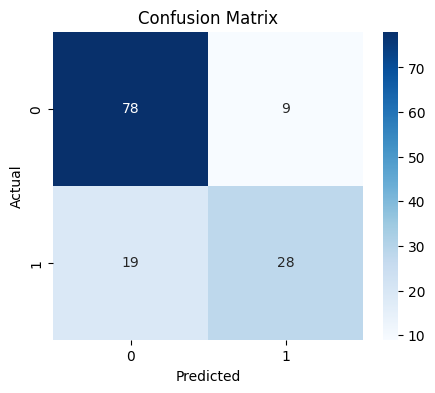

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict on test set
y_pred = best_model.predict(X_test)

# Evaluate performance
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix visualization
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


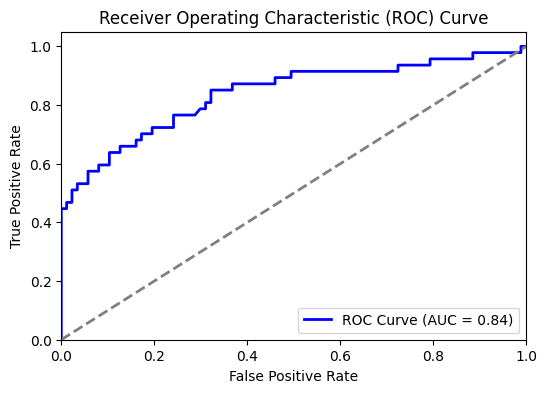

In [ ]:
from sklearn.metrics import roc_curve, auc

# Ensure y_pred_proba is generated from predict_proba() for ROC-AUC
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Extract probability scores for the positive class

# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color="blue", lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", lw=2)  # Baseline
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


In [ ]:
import pickle

# Save the trained model
with open("titanic_model.pkl", "wb") as model_file:
    pickle.dump(best_model, model_file)

# Save the scaler (if required)
with open("scaler.pkl", "wb") as scaler_file:
    pickle.dump(scaler, scaler_file)


In [ ]:
import joblib

# Save trained model
joblib.dump(best_model, "model.pkl")


['model.pkl']

In [ ]:
from fastapi import FastAPI
import joblib
import numpy as np
import uvicorn
import nest_asyncio

# Apply workaround for running FastAPI inside Jupyter Notebook
nest_asyncio.apply()

# Load the saved model
model = joblib.load("model.pkl")

# Initialize FastAPI app
app = FastAPI()

@app.get("/")
def home():
    return {"message": "FastAPI Model Deployment is running!"}

@app.post("/predict/")
def predict(features: list):
    try:
        # Convert input to NumPy array and reshape
        input_data = np.array(features).reshape(1, -1)

        # Make prediction
        prediction = model.predict(input_data)[0]
        probability = model.predict_proba(input_data)[0].tolist()

        return {
            "Predicted Class": int(prediction),
            "Prediction Probability": probability
        }
    except Exception as e:
        return {"error": str(e)}

# Run FastAPI Server
uvicorn.run(app, host="127.0.0.1", port=8000)


INFO:     Started server process [166]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


In [ ]:
import nest_asyncio
nest_asyncio.apply()
